# 5-5 Pytorch實作: 透過LSTM進行多股價預測實例操作


我們要做的事情是單一股票預測，變成股票之間有關連性的LSTM預測，見下圖。<br>
假設有三家公司分別為ABC<br>
- 單一股價預測為上半部，用單一公司的五天的歷史收盤價進行第六天的股價預測。
- 多股價部分則是會將三家公司的股價變成一個向量，進行五天的歷史收盤價進行第六天這三家公司的股價預測(下圖下半部)。

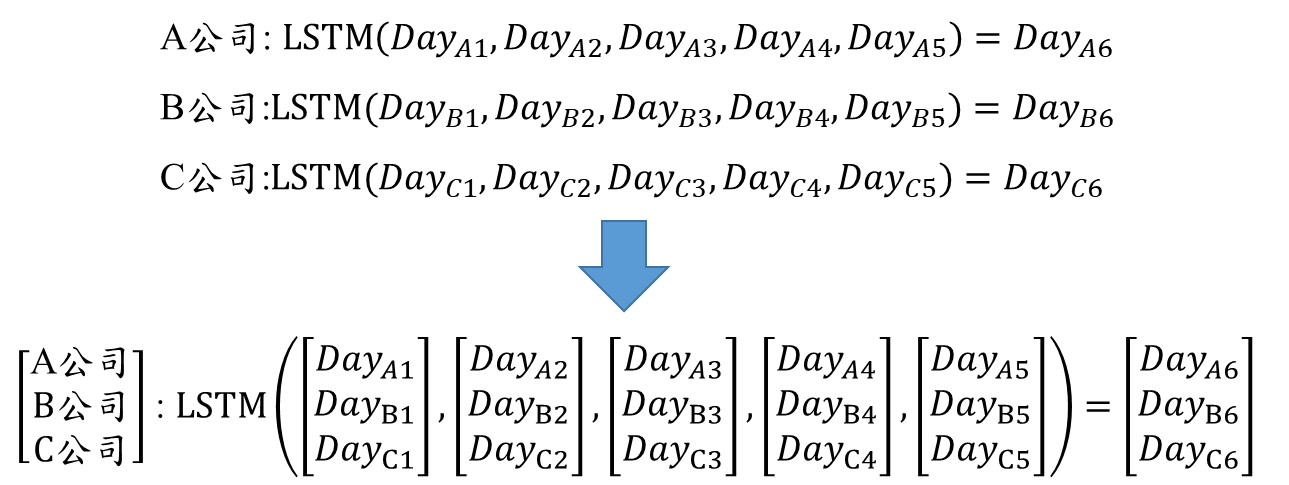

我們這邊找一個台積電的概念股，如下。

[台積電供應鏈概念股行情](https://tw.stock.yahoo.com/class-quote?category=%E5%8F%B0%E7%A9%8D%E9%9B%BB%E4%BE%9B%E6%87%89%E9%8F%88&categoryLabel=%E6%A6%82%E5%BF%B5%E8%82%A1)
台灣積體電路製造: 2330.TW

|股票名稱|代號|股票名稱|代號|股票名稱|代號|股票名稱|代號|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|中砂|1560.TW|勝一|1773.TW|光洋科|1785.TWO|漢唐|2404.TW|
|盟立|2464.TW|弘塑|3131.TWO|精材|3374.TWO|京鼎|3413.TW|
|創意|3443.TW|世禾|3551.TWO|辛耘|3583.TW|巨有科技|8227.TWO|
|家登|3680.TWO|日月光投控|3711.TW|三福化|4755.TW|上品|4770.TW|
|世界|5347.TWO|聖暉*|5536.TWO|帆宣|6196.TW|日揚|6208.TWO|
|迅得|6438.TW|環球晶|6488.TWO|精測|6510.TWO|愛普*|6531.TW|
|信紘科|6667.TWO|洋基工程|6691.TW|濾能|6823.TWO|昇陽半導體|8028.TW|
|翔名|8091.TWO|


In [1]:
companies={}
companies['台灣積體電路製造']='2330.TW'
companies['中砂']='1560.TW' #
# companies['勝一']='1773.TW'
companies['光洋科']='1785.TWO' #
# companies['漢唐']='2404.TW'
# companies['盟立']='2464.TW'
# companies['弘塑']='3131.TWO'
# companies['精材']='3374.TWO'
# companies['京鼎']='3413.TW'
# companies['創意']='3443.TW'
# companies['世禾']='3551.TWO'
companies['辛耘']='3583.TW' #
# companies['家登']='3680.TWO'
companies['日月光投控']='3711.TW' #
# companies['三福化']='4755.TW'
# companies['上品']='4770.TW'
# companies['世界']='5347.TWO'
# companies['聖暉*']='5536.TWO'
# companies['帆宣']='6196.TW'
# companies['日揚']='6208.TWO'
# companies['迅得']='6438.TW'
# companies['環球晶']='6488.TWO'
# companies['精測']='6510.TWO'
companies['愛普*']='6531.TW' #
# companies['信紘科']='6667.TWO'
# companies['洋基工程']='6691.TW'
# companies['濾能']='6823.TWO'
# companies['昇陽半導體']='8028.TW'
# companies['翔名']='8091.TWO'
# companies['巨有科技']='8227.TWO'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import numpy as np
import time
import torch
import torch.nn as nn

n_days=200
n_companies = len(companies)
c=0
for tmp in companies:
    df = yf.Ticker(companies[tmp])
    price = df.history(period="max").Close
    price = price[-n_days-1:-1]
    price=pd.DataFrame(price)
    price = price.rename(columns={price.columns[0]: tmp})
    if c==0:
        DATA=price
    else:
        DATA= pd.merge(left = DATA,
                       right = price,
                       left_on='Date',
                       right_on='Date')
    c+=1

C:\Users\glanb\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DATA

,台灣積體電路製造,中砂,光洋科,辛耘,日月光投控,愛普*
Date,,,,,,
2022-09-27 00:00:00+08:00,440.974121,125.272751,31.223297,69.221802,75.278564,151.738434
2022-09-28 00:00:00+08:00,431.130951,117.533897,28.149002,64.333252,72.586723,142.927811
2022-09-29 00:00:00+08:00,428.178009,116.082855,28.437220,65.310966,73.236481,143.906769
2022-09-30 00:00:00+08:00,415.381897,117.050217,28.725433,66.777527,74.350342,149.780518
2022-10-03 00:00:00+08:00,410.460297,118.017570,28.725433,65.897591,71.565681,149.780518
...,...,...,...,...,...,...
2023-07-21 00:00:00+08:00,560.000000,143.500000,36.599998,188.500000,110.500000,307.500000
2023-07-24 00:00:00+08:00,558.000000,141.500000,35.599998,193.000000,110.500000,300.000000
2023-07-25 00:00:00+08:00,569.000000,149.000000,36.150002,212.000000,114.500000,310.500000


In [4]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers    
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers, 
                            batch_first=True,
                            dropout = 0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# def split_data(stock, lookback):
#     data_raw = np.array(stock)
#     n_time = len(data_raw)
#     data, targets = [], []
#     for index in range(n_time - lookback): 
#         data.append(   data_raw[index: index + lookback])
#         targets.append(data_raw[index + lookback])
    
#     data = np.array(data)
#     targets = np.array(targets)
#     print('總資料量:{}'.format(data.shape))
#     test_set_size = int(np.round(0.2*data.shape[0]));
#     train_set_size = data.shape[0] - (test_set_size);
    
#     x_train = data[:train_set_size,:]
#     y_train = targets[:train_set_size]
    
#     x_test = data[train_set_size:,:]
#     y_test = targets[train_set_size:]
    
#     return [x_train, y_train, x_test, y_test]


def split_data_random(stock, lookback):
    data_raw = np.array(stock)
    n_time = len(data_raw)
    data, targets = [], []
    for index in range(n_time - lookback): 
        data.append(   data_raw[index: index + lookback])
        targets.append(data_raw[index + lookback])
    
    data = np.array(data)
    targets = np.array(targets)
    print('總資料量:{}'.format(data.shape))
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    randpos = np.random.permutation(data.shape[0])
    x_train = data[randpos[:train_set_size],:]
    y_train = targets[randpos[:train_set_size]]
    
    x_test = data[randpos[train_set_size:],:]
    y_test = targets[randpos[train_set_size:]]
    
    return [x_train, y_train, x_test, y_test]

In [5]:
from sklearn.preprocessing import StandardScaler
DATA_=[]
scaler=[]
for i in range(n_companies):
    scaler.append(StandardScaler())
    DATA_.append(scaler[i].fit_transform(DATA.values[:,i].reshape(-1,1)))
DATA_= np.array(DATA_)
DATA_= np.squeeze(DATA_)
DATA_ = np.transpose(DATA_, (1,0))
DATA_.shape

(200, 6)

In [6]:
lookback = 5 # choose sequence length
x_train, y_train, x_test, y_test = split_data_random(DATA_, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

總資料量:(195, 5, 6)
x_train.shape =  (175, 5, 6)
y_train.shape =  (175, 6)
x_test.shape =  (20, 5, 6)
y_test.shape =  (20, 6)


In [7]:
use_cuda=0
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
input_dim = n_companies
hidden_dim = 64
num_layers = 3
output_dim = n_companies
num_epochs = 150

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

x_train_ = torch.FloatTensor(x_train)
y_train_ = torch.FloatTensor(y_train)
x_test_ = torch.FloatTensor(x_test)
y_test_ = torch.FloatTensor(y_test)

# hist = np.zeros(num_epochs)
# start_time = time.time()
# model.train()
# for t in range(num_epochs):
#     y_train_pred = model(x_train_)
#     loss = criterion(y_train_pred, y_train_)
#     hist[t] = loss.item()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if t%100==0:
#         print("Epoch ", t, "MSE: ", loss.item())
#     scheduler.step()
    
# training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

datasets_train = torch.utils.data.TensorDataset(x_train_, y_train_)
datasets_test = torch.utils.data.TensorDataset(x_test_, y_test_)
dataloader_train = torch.utils.data.DataLoader(datasets_train, batch_size=32, shuffle=True,num_workers=0)
dataloader_test = torch.utils.data.DataLoader(datasets_test, batch_size=64, shuffle=False,num_workers=0)
hist = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data=data.to(device)
        target=target.to(device)
        y_train_pred = model(data)
        loss = criterion(y_train_pred, target)
        hist.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%10==0:
        model.eval()
        loss_record=0
        for _, (data, target) in enumerate(dataloader_test):
            data=data.to(device)
            target=target.to(device)
            y_pred = model(data)
            loss = criterion(y_pred, target)
            loss_record+=loss.item()
        print("Epoch ", epoch, "MSE: ", loss_record/len(dataloader_test))
    scheduler.step()
    

Epoch  0 MSE:  0.6145077347755432
Epoch  10 MSE:  0.11221635341644287
Epoch  20 MSE:  0.06284573674201965
Epoch  30 MSE:  0.0561300590634346
Epoch  40 MSE:  0.04690581560134888
Epoch  50 MSE:  0.0414302796125412
Epoch  60 MSE:  0.040398307144641876
Epoch  70 MSE:  0.04466899111866951
Epoch  80 MSE:  0.04009408503770828
Epoch  90 MSE:  0.042615510523319244
Epoch  100 MSE:  0.03994058817625046
Epoch  110 MSE:  0.0404849499464035
Epoch  120 MSE:  0.039832551032304764
Epoch  130 MSE:  0.03983785957098007
Epoch  140 MSE:  0.03946387767791748


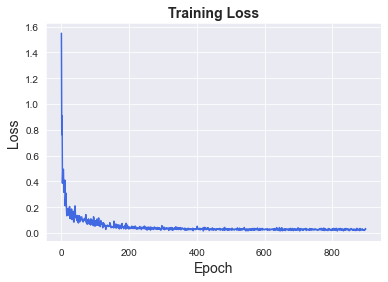

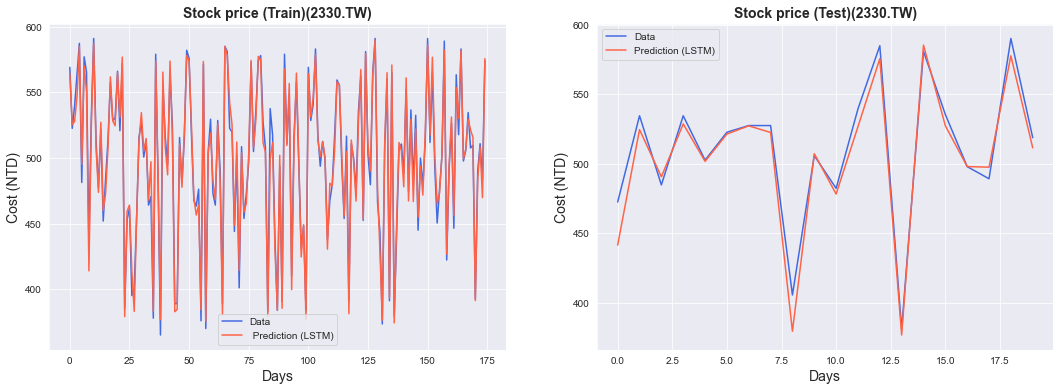

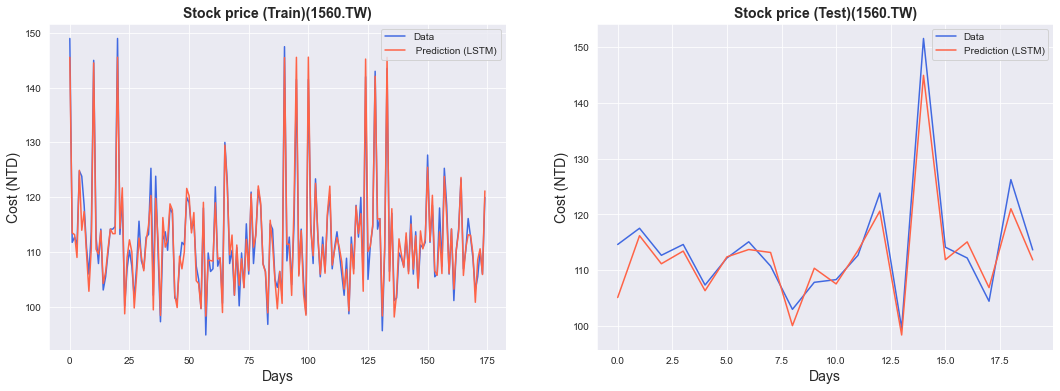

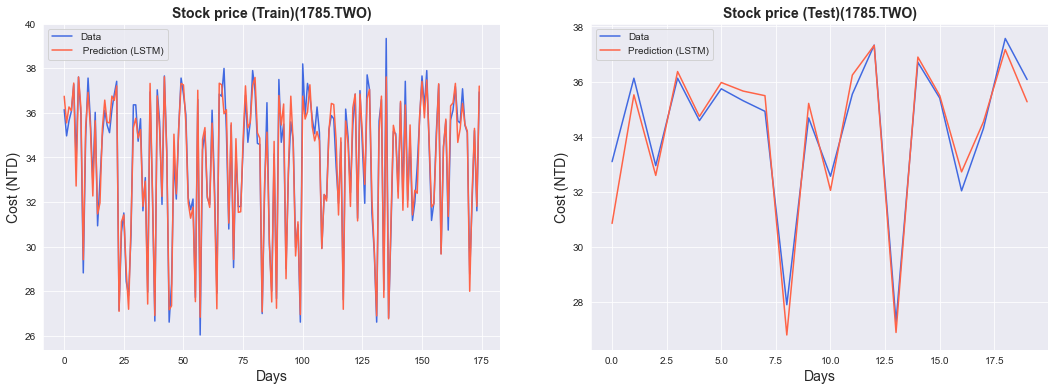

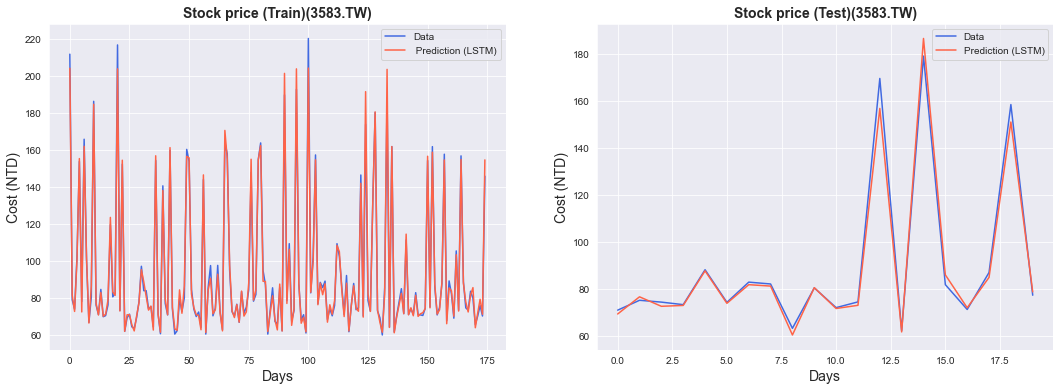

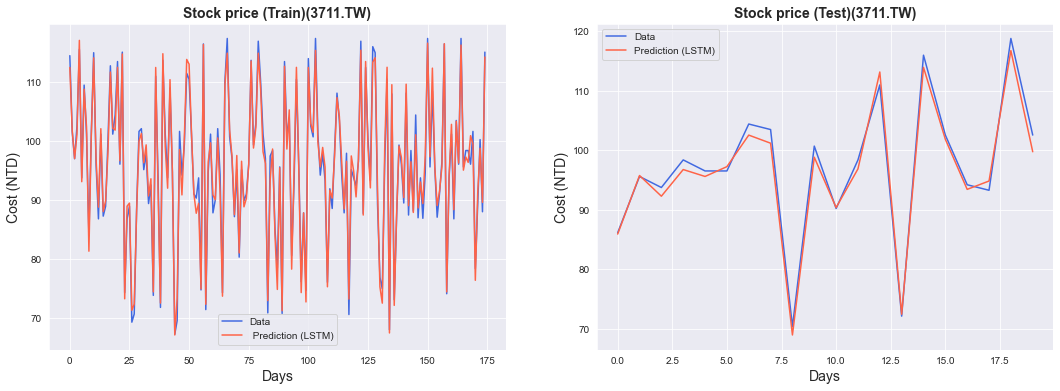

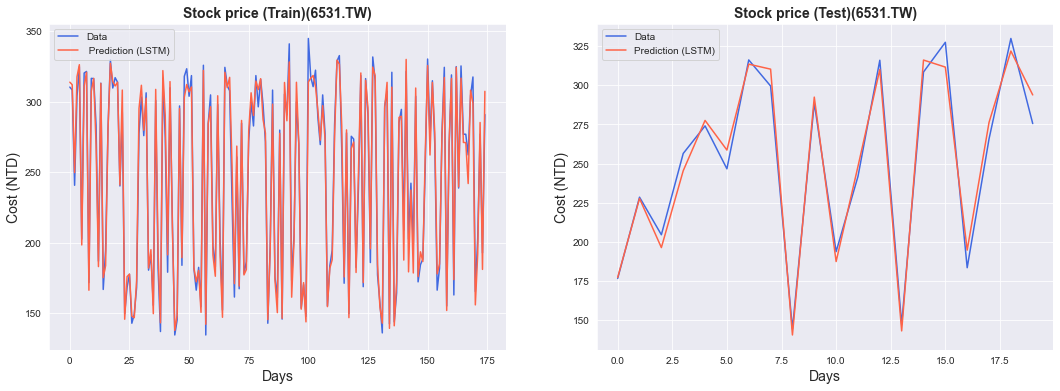

In [8]:
import seaborn as sns

sns.set_style("darkgrid")    
fig = plt.figure()
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

model.eval()
for i_index, tmp_name in enumerate(companies):
    tmp = companies[tmp_name]
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    with torch.no_grad():
        y_train_pred = model(x_train_)
    
    predict=[]
    for i in range(n_companies):
        predict.append(scaler[i].inverse_transform(y_train_pred[:,i].detach().numpy().reshape(-1,1)))
    predict=np.array(predict)
    predict= np.squeeze(predict)
    predict = np.transpose(predict, (1,0)) 
    original=[]
    for i in range(n_companies):
        original.append(scaler[i].inverse_transform(y_train_[:,i].detach().numpy().reshape(-1,1)))
    original=np.array(original)
    original= np.squeeze(original)
    original = np.transpose(original, (1,0))
    original.shape
    predict = pd.DataFrame(predict)
    original = pd.DataFrame(original)
    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[i_index], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[i_index], label=" Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price (Train)({})'.format(tmp), size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (NTD)", size = 14)
    # plt.ylim([500,950])
    # ax.set_xticklabels('', size=10)
    
    
    with torch.no_grad():
        y_test_pred = model(x_test_)
        
    predict=[]
    for i in range(n_companies):
        predict.append(scaler[i].inverse_transform(y_test_pred[:,i].detach().numpy().reshape(-1,1)))
    predict=np.array(predict)
    predict= np.squeeze(predict)
    predict = np.transpose(predict, (1,0))
    
    original=[]
    for i in range(n_companies):
        original.append(scaler[i].inverse_transform(y_test_[:,i].detach().numpy().reshape(-1,1)))
    original=np.array(original)
    original= np.squeeze(original)
    original = np.transpose(original, (1,0))

    predict = pd.DataFrame(predict)
    original = pd.DataFrame(original)
    plt.subplot(1, 2, 2)
    ax = sns.lineplot(x = original.index, y = original[i_index], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[i_index], label="Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price (Test)({})'.format(tmp), size = 14, fontweight='bold')

    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (NTD)", size = 14)
#     plt.ylim([500,950])

    # ax.set_xticklabels('', size=10)
    fig.set_figheight(6)
    fig.set_figwidth(18)

## 利用預設的結果繼續預測

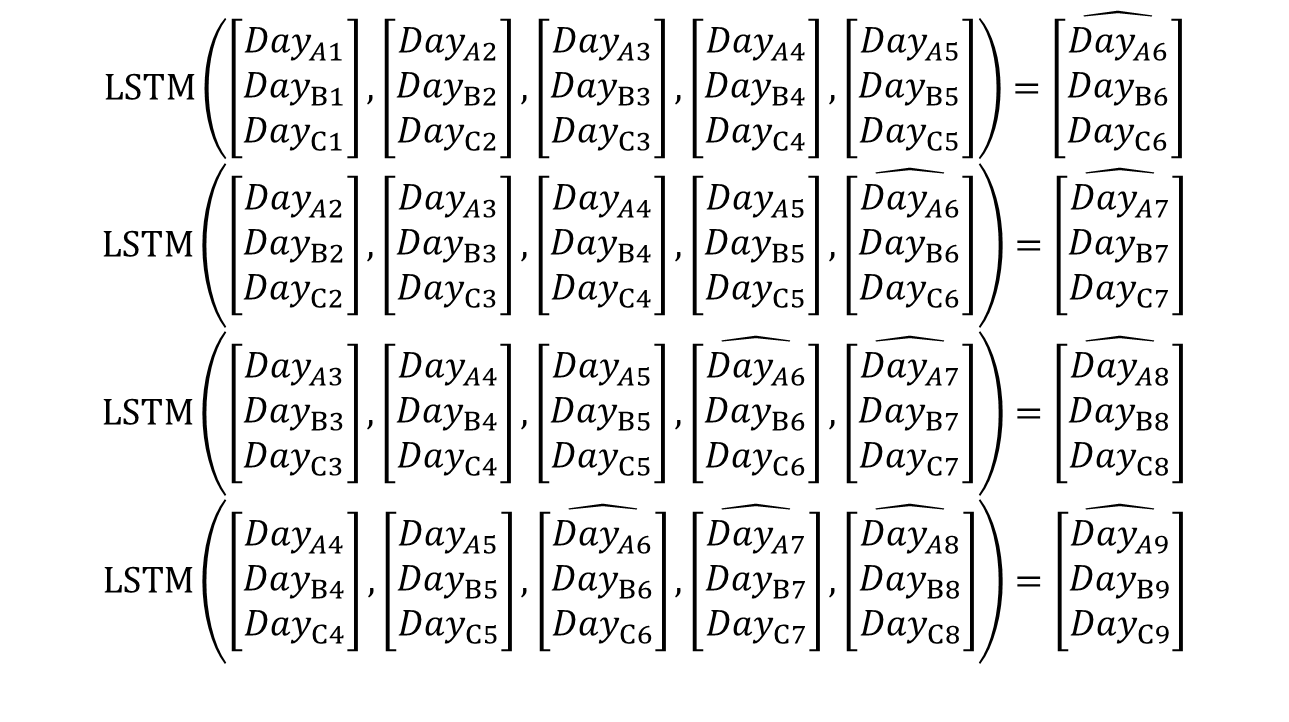

In [9]:
x=DATA_[-100:]
real_targets=[]
predicts=[]
for i in range(90):
    price_manual = np.array(x[i:i+lookback,:]) 
    real_targets.append(np.array(x[i+lookback,:]))
    
    price_manual = torch.FloatTensor(price_manual)
    price_manual = price_manual.unsqueeze(0)
    y_test_pred = model(price_manual)
    predicts.append(y_test_pred.detach().numpy().squeeze())
# predicts=np.array(predicts)
real_targets=np.array(real_targets)
real_targets.shape

st = 90-lookback
for t in range(10):
    price_manual=[]
    c=0
    for j in range(lookback):
        try: 
            price_manual.append(x[st+j])
        except:
#             price_manual.append(predicts[-1-c])
            price_manual.append(predicts[st+j])
            c+=1
    st+=1
    price_manual = np.array(price_manual) 
    price_manual = torch.FloatTensor(price_manual)
    y_test_pred = model(price_manual.unsqueeze(0))
    predicts.append(y_test_pred.squeeze().detach().numpy())
predicts=np.array(predicts)
    
predict=[]
for i in range(n_companies):
    predict.append(scaler[i].inverse_transform(predicts[:,i].reshape(-1,1)))
predict=np.array(predict)
predict= np.squeeze(predict)
predict = np.transpose(predict, (1,0))    
    
    
original=[]
for i in range(n_companies):
    original.append(scaler[i].inverse_transform(real_targets[:,i].reshape(-1,1)))
original=np.array(original)
original= np.squeeze(original)
original = np.transpose(original, (1,0))

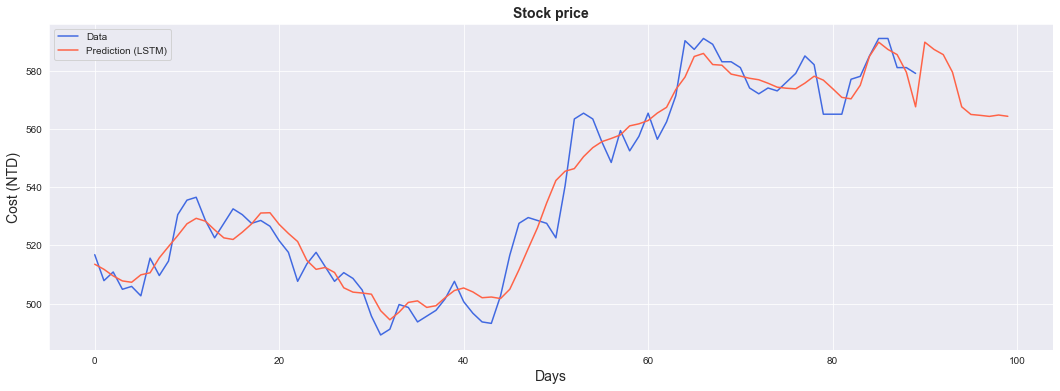

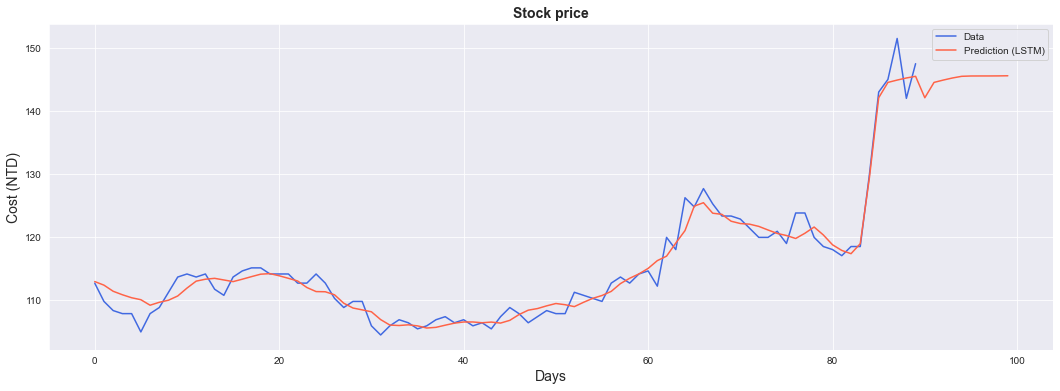

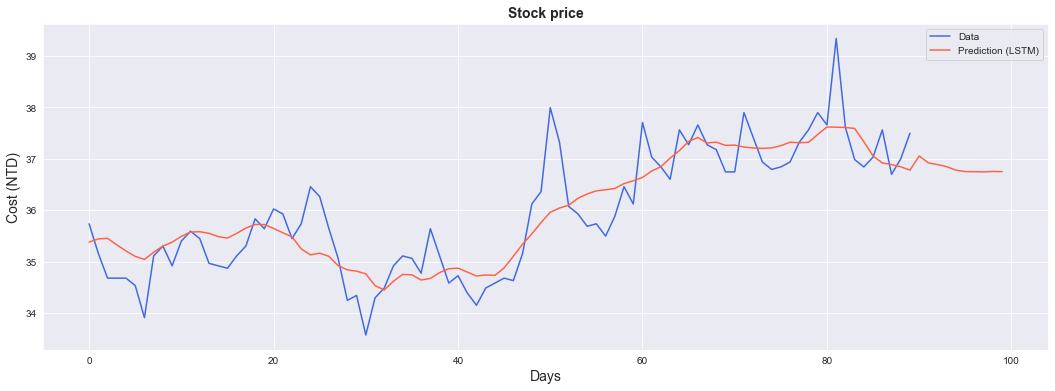

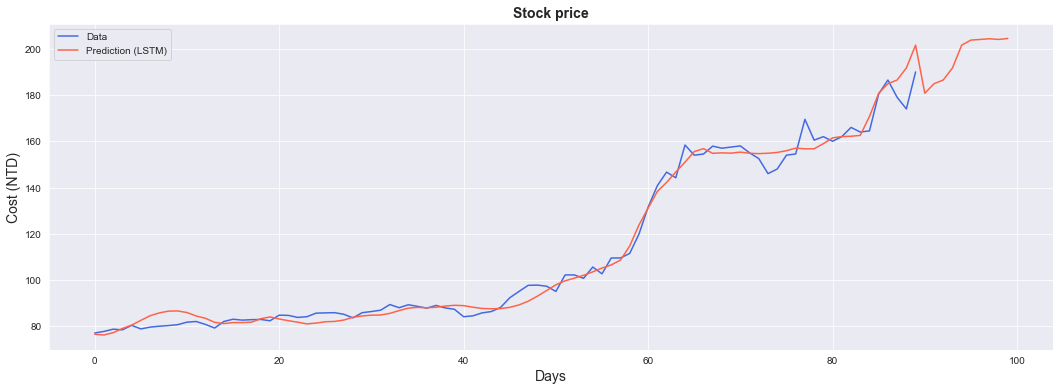

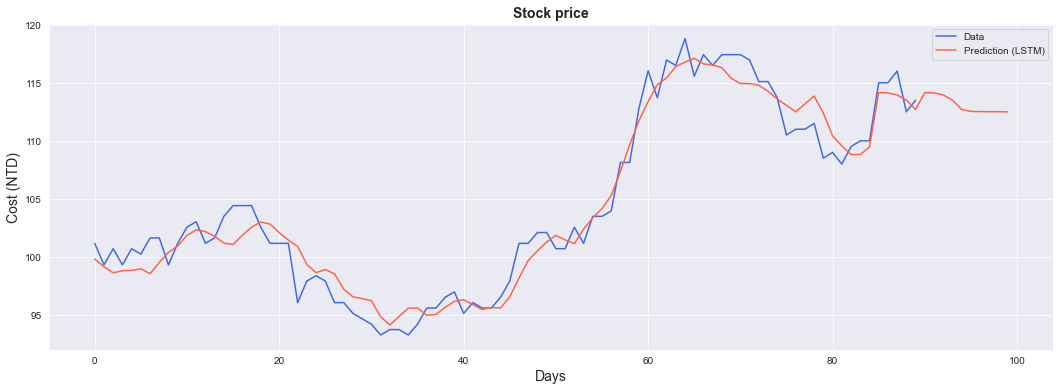

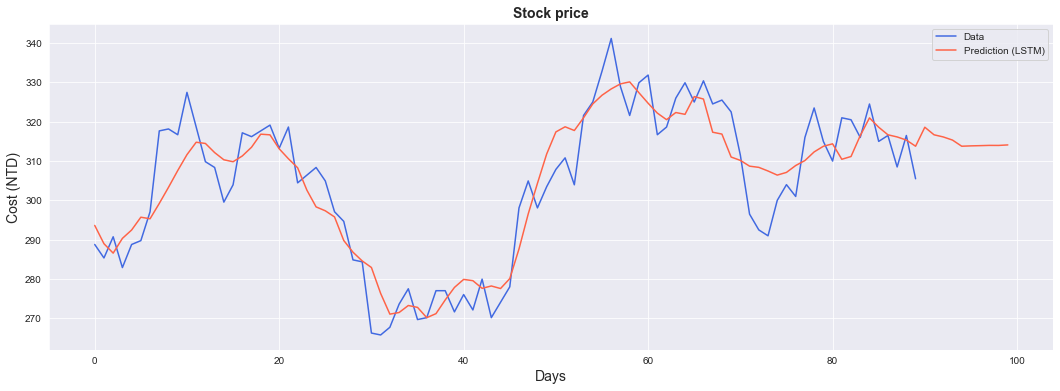

In [10]:
for t in range(n_companies):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    predict = pd.DataFrame(predict)
    original = pd.DataFrame(original)
    ax = sns.lineplot(x = original.index, y = original[t], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[t], label="Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (NTD)", size = 14)

    fig.set_figheight(6)
    fig.set_figwidth(18)